# Personalized correlations PNP3

 *Wake up glucose vs diet the day before*

The idea is that wakeup glucose is not the same on different days for the same person. I want to understand if it is due to the dietal behavior the day before. Also I want to see if associations between the food in the previous day and the wakeup glucose are different for different people. PNP3 cohort is suitable for this purpose because each person had more than 100 days of CGM connections.

I have to start with computing the wakeup glucose for all the people and each day. The method is to use the time between 6 and 7 unless a person logged the food at this time. Also I have to filter out days and people who logged any food after midnight.

In [575]:
import pandas as pd
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
import datetime
%matplotlib inline
cgml = CGMLoader()
dll = DietLoggingLoader()

In [264]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [479]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection

## Calculating wakeup glucose

This function will only suit for pnp3 because it involves adding adjusted glucose from a file outside LabData. 

In [531]:
def calculate_wakeup_glucose_pnp3(time_between = [5,7], study_ids=[3,49]):    

    """Calculates wakeup glucose in the interval given in time_between 
    depending on the breakfast time"""
    
    # Get the cgm df and combine it with adjusted glucose 
    cgmdf = cgml.get_data(study_ids=study_ids).df
    cgmdf = cgml._remove_first_day_of_connections(cgmdf)
    cgmdf = cgmdf.reset_index()
    cgmdf['hour'] = cgmdf.Date.dt.hour
    cgmdf = cgmdf.set_index('Date')
    cgmdf.index = cgmdf.index.tz_localize(None)
    adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
    adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
    adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
    adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})
    adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
    cgm_adj = pd.merge(cgmdf, adj_gluc['GlucoseAdj50N13_Mm'], on=['ConnectionID', 'Date'])
    cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

    #  Get the log df 
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, ['energy_kcal'])
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    
    # Filter out beverages with 0 kcal
    logdf = logdf[logdf['energy_kcal'] != 0]
    
    # Filter out days with first meals earlier than 6 am 
    firstmeals = pd.DataFrame(logdf.groupby(['RegistrationCode', 'Day'])['Date'].first().rename('breakfast_ts'))
    firstmeals = firstmeals[(firstmeals['breakfast_ts'].dt.time > datetime.time(6, 0, 0))]
    
    # Dtype handling. After groupby 'Day' is an object, but I need it to be datetime
    firstmeals = firstmeals.reset_index('Day')
    firstmeals['Day'] = pd.to_datetime(firstmeals['Day'])
    firstmeals = firstmeals.set_index('Day', append=True)
    cgm_adj['Day'] = cgm_adj.index.date
    cgm_adj = cgm_adj.set_index(['RegistrationCode', 'Day'])
    
    # Get cgm and firstmeals ts in one df
    cgm_fm = pd.merge(cgm_adj, firstmeals, on=['RegistrationCode', 'Day'])
    
    # Leave cgm timestamps between 5 and 7 only
    cgm_fm = cgm_fm[(cgm_fm['hour'] >= time_between[0]) & (cgm_fm['hour'] < time_between[1])]
    
    # If breakfast was between 6 and 7 then wakeup glucose is a mean value between 5 and 6, otherwise between 6 and 7
    cgm_fm = cgm_fm[((cgm_fm['hour'] == time_between[0]) & (cgm_fm['breakfast_ts'].dt.hour == time_between[0] + 1)) | 
                    ((cgm_fm['hour'] == time_between[0] + 1) & (cgm_fm['breakfast_ts'].dt.hour >= time_between[1]))]
    wakeup_glucose = pd.DataFrame(cgm_fm.reset_index().groupby(['RegistrationCode', 'Day', 'hour'])['GlucoseAdj'].mean().rename(
                                'wakeup_glucose'))
    
    return wakeup_glucose

In [532]:
wakeup_glucose_test = calculate_wakeup_glucose_pnp3()

In [535]:
wakeup_glucose_test.head()

wakeup_glucose
RegistrationCode Day        hour                
111527           2017-11-08 5         103.071429
                 2017-11-10 5          98.071429
                 2017-11-11 6         101.321429
                 2017-11-12 6         107.071429
                 2017-11-13 6         106.071429

## Wakeup glucose variability distribution

In [135]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def interquartile_range(x):
    return q3(x) - q1(x)

f = {'wakeup_glucose': ['median', 'std', q1,q3, interquartile_range]}

In [136]:
morn_gluc_distr = wakeup_glucose.groupby('RegistrationCode').agg(f)

In [108]:
morn_gluc_distr.columns = morn_gluc_distr.columns.droplevel()

In [137]:
morn_gluc_distr.sample(10)

wakeup_glucose             ...                                
                         median        std  ...          q3 interquartile_range
RegistrationCode                            ...                                
173854                87.145833  14.927984  ...   91.647321           12.959821
772380                96.250000   5.252915  ...  100.700000            7.562500
252002                97.649573   9.253903  ...  105.050000           12.130682
794542               126.634615  12.311187  ...  132.849359           10.974359
130279                99.375000  11.034922  ...  105.468750           10.883523
132178               109.375000   8.970829  ...  114.669643           11.794643
439484                95.250000  10.592360  ...   98.919643            8.453734
742096                92.333333   5.377542  ...   95.603147            7.487762
997427               107.766667   7.604173  ...  111.968531            8.697698
64952                 89.289773   8.936098  ...   94.250000            9.326705

[10 rows x 5 columns]

In [122]:
fig = plt.figure(figsize=(7,5))
fig.suptitle('Intrapersonal variability of the morning glucose in PNP3', fontsize=18)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Interquartile range')
morn_gluc_distr['interquartile_range'].plot.hist()

In [123]:
morn_gluc_distr['interquartile_range'].mean()

11.936180075658099

### Todo: I should look at this values before and after the intervention and compare changes for the two diets. 

In [152]:
wakeup_glucose.shape

(25799, 4)

For how many days did people wear CGM sensor?

In [143]:
count = wakeup_glucose.groupby('RegistrationCode')['Day'].count()

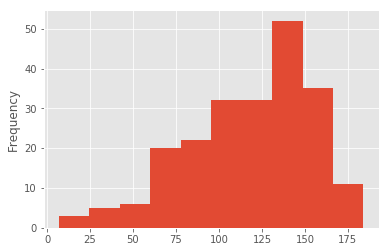

In [144]:
count.plot.hist()

Let's take all people with at least 50 days of  connections.

In [149]:
rc_to_keep = count[count >= 50].index

In [536]:
len(rc_to_keep)

207

We have 207 people in total.

## Leave only those people with more than 50 days of connections

In [543]:
def more_than_x_connection_days(wakeup_glucose_df, x=50):
    wakeup_glucose_df = wakeup_glucose_df.reset_index()
    count = wakeup_glucose_df.groupby('RegistrationCode')['Day'].count()
    rc_to_keep = count[count >= 50].index
    # wakeup_glucose = wakeup_glucose.set_index('RegistrationCode').loc[rc_to_keep]
    wakeup_glucose_df = wakeup_glucose_df[wakeup_glucose_df['RegistrationCode'].isin(rc_to_keep)]
    return wakeup_glucose_df

In [544]:
wakeup_glucose_test = more_than_x_connection_days(wakeup_glucose_test)

In [547]:
wakeup_glucose_test.head()

RegistrationCode        Day  hour  wakeup_glucose
0           111527 2017-11-08     5      103.071429
1           111527 2017-11-10     5       98.071429
2           111527 2017-11-11     6      101.321429
3           111527 2017-11-12     6      107.071429
4           111527 2017-11-13     6      106.071429

## Dietary features from the day before

In [ ]:
def prepare_data_for_corr(wg_df, nutrient_list, study_ids=[3,49], min_cal_per_day=1000, how='total_diet', daysplithours=[6,12,18]):
    
    """Prepare joint df with wg and dietary features from the day before.
    One can choose to correlate with total diet from the perevious day or with diet split into breakfast, lunch and dinner.
    :param wg_df : wakeup_glucose DataFrame
    :param nutrient_list: list of nutrients to select (for the full list see LabData/DataLoaders/Lists/meal_features.txt)
                                e.g. ['energy_kcal', 'carbohydrate_g', 'protein_g', 'totallipid_g']
                                if None, all nutrients are selected
    :param min_cal_per_day:
    :param how: string, can be 'total_diet' or 'split_diet'. If split_diet is passed, then the day will be split into breakfast,
                        lunch and dinner and the nutrients will be calculated accordingly.
    :param daysplithours: list telling how to split the day 
        
    :return data_df with wg and dietary features to perform the correlations with
    """ 
    carbs_cal_per_gram = 4
    fat_cal_per_gram = 9
    prot_cal_per_gram = 4
    
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, nutrient_list)
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    #Identify days with good log more than min_cal_per_day
    totaldaylog = logdf.drop(columns=['meal_type']).groupby(['RegistrationCode', 'Day']).sum()
    totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= min_cal_per_day]
    days_to_keep = totaldaylog.index
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[days_to_keep]
    
    if how == 'total_diet':
        # Add derived  features
        totaldaylog['carbs/lipids'] = totaldaylog['carbohydrate_g'] / totaldaylog['totallipid_g']
        totaldaylog['caloric%carbs'] = totaldaylog['carbohydrate_g'] * carbs_cal_per_gram / totaldaylog['energy_kcal']
        totaldaylog['caloric%protein'] = totaldaylog['protein_g'] * prot_cal_per_gram / totaldaylog['energy_kcal']
        totaldaylog['caloric%fat'] = totaldaylog['totallipid_g'] * fat_cal_per_gram / totaldaylog['energy_kcal']
        # Change dtype to datetime for merge with wg_df
        totaldaylog = totaldaylog.reset_index('Day')
        totaldaylog['Day'] = pd.to_datetime(totaldaylog['Day'])
        # Add day to the current day for merge with correct wg
        totaldaylog['Day'] = totaldaylog['Day'] + datetime.timedelta(days=1)
        data_for_corr = pd.merge(wakeup_glucose, totaldaylog, on=['RegistrationCode', 'Day'])
        
    elif how == 'split_diet':
        

        pass
    
    return data_for_corr
        
    
    

Dietary features to test the correlations on:
'alcohol_g', 'caffeine_mg', 'carbohydrate_g', 'carbs/fat', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g'

In [577]:
 log = dll.get_data(study_ids=[3,49]).df

In [578]:
logdf = dll.add_nutrients(log,['caffeine_mg', 'carbohydrate_g', 'energy_kcal', 
                       'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g'])

In [579]:
logdf = dll.squeeze_log(logdf)

sodium_mg  ...  meal_type
RegistrationCode Date                                  ...           
111527           2017-10-06 09:46:44+03:00      9.800  ...   Beverage
                 2017-10-06 11:48:01+03:00    311.000  ...       Meal
                 2017-10-06 11:53:29+03:00     64.995  ...   Beverage
                 2017-10-06 13:17:55+03:00     14.400  ...   Beverage
                 2017-10-06 14:10:52+03:00     19.200  ...   Beverage

[5 rows x 10 columns]

In [587]:
logdf = logdf.reset_index()

In [589]:
logdf['Day'] = logdf['Date'].dt.date

In [582]:
daysplithours=[6, 12, 18]

In [583]:
logdf['alloc'] = ''
logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[0], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[1], 0, 0)),'alloc'] = 'b'
logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[1], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'l'
logdf.loc[(logdf['Date'].dt.time > datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'd'

In [606]:
# We are only interested in  food between 6 and 24, days where people logged food during the night will be out after merge with wg_df
logdf = logdf[logdf['alloc'] != '']

In [607]:
logdf.shape

(232563, 12)

In [590]:
logdf = logdf.set_index(['RegistrationCode', 'Day'])

In [603]:
logdf = logdf.drop(columns='index')

In [609]:
splitlog = logdf.reset_index().groupby(['RegistrationCode', 'Day', 'alloc']).sum()
splitlog = splitlog.unstack(level=-1)
splitlog

sodium_mg             ... caffeine_mg       
alloc                                  b          d  ...           d      l
RegistrationCode Day                                 ...                   
111527           2017-10-06   385.795000  822.96000  ...       112.5  108.0
                 2017-10-07   736.940200  964.82000  ...       145.0    0.0
                 2017-10-08   563.974000  181.77000  ...         0.0  108.0
                 2017-11-05   425.400000  178.85000  ...       108.0  155.4
                 2017-11-06   693.500000   20.18750  ...       112.5  155.4
...                                  ...        ...  ...         ...    ...
997735           2019-07-20   974.514601   46.90000  ...         0.0    NaN
                 2019-10-28  1643.188640  766.49220  ...        14.2    0.0
                 2019-10-29  1676.700580  605.33575  ...        14.2    0.0
                 2019-11-02   205.802160  132.00000  ...         0.0    0.0
                 2019-11-03  1505.654500  333.91660  ...         0.0    0.0

[43597 rows x 27 columns]

In [611]:
print(splitlog.columns)

MultiIndex([(          'sodium_mg', 'b'),
            (          'sodium_mg', 'd'),
            (          'sodium_mg', 'l'),
            (      'sugarstotal_g', 'b'),
            (      'sugarstotal_g', 'd'),
            (      'sugarstotal_g', 'l'),
            (       'totallipid_g', 'b'),
            (       'totallipid_g', 'd'),
            (       'totallipid_g', 'l'),
            (          'protein_g', 'b'),
            (          'protein_g', 'd'),
            (          'protein_g', 'l'),
            (     'carbohydrate_g', 'b'),
            (     'carbohydrate_g', 'd'),
            (     'carbohydrate_g', 'l'),
            ('totaldietaryfiber_g', 'b'),
            ('totaldietaryfiber_g', 'd'),
            ('totaldietaryfiber_g', 'l'),
            (        'energy_kcal', 'b'),
            (        'energy_kcal', 'd'),
            (        'energy_kcal', 'l'),
            (             'weight', 'b'),
            (             'weight', 'd'),
            (             'weight'

In [ ]:
splitlogitlog.columns = ['b_caffeine','l_caffeine','d_caffeine','n_caffeine',
                             'a_totallipid', 'b_totallipid', 'l_totallipid', 'd_totallipid', 'n_totallipid',
                             'a_energy', 'b_energy', 'l_energy', 'd_energy', 'n_energy',
                             'a_carbohydrate', 'b_carbohydrate', 'l_carbohydrate', 'd_carbohydrate', 'n_carbohydrate',
                             'a_alcohol', 'b_alcohol', 'l_alcohol', 'd_alcohol', 'n_alcohol',
                             'a_protein', 'b_protein', 'l_protein', 'd_protein', 'n_protein']

Let's start with correlating with the total amounts per day.

On some of the days log is not good enough, people logged too little calories per day which can't be representative. 

In [302]:
totaldaylog['energy_kcal'].plot.hist()

I take the threshold of 1000 kcal per day.

In [596]:
totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= 1000]

In [307]:


totaldaylog = totaldaylog.reset_index('Day')
totaldaylog['Day'] = totaldaylog['Day'] + datetime.timedelta(days=1)

totaldaylog.sample(5)

totaldaylog['Day'] = pd.to_datetime(totaldaylog['Day'])

data = pd.merge(wakeup_glucose, totaldaylog, on=['RegistrationCode', 'Day'])

In [556]:
totaldaylog.head()

Day    sodium_mg  ...  caloric%protein  caloric%fat
RegistrationCode                          ...                              
111527           2017-10-07  3522.806605  ...         0.181533     0.437665
111527           2017-10-08  1823.482200  ...         0.138992     0.523934
111527           2017-10-09   875.554000  ...         0.174930     0.415108
111527           2017-11-06  2046.856887  ...         0.136541     0.488059
111527           2017-11-07  1454.499167  ...         0.119297     0.283822

[5 rows x 15 columns]

In [555]:
carbs_cal_per_gram = 4
fat_cal_per_gram = 9
prot_cal_per_gram = 4
totaldaylog['carbs/lipids'] = totaldaylog['carbohydrate_g'] / totaldaylog['totallipid_g']
totaldaylog['caloric%carbs'] = totaldaylog['carbohydrate_g'] * carbs_cal_per_gram / totaldaylog['energy_kcal']
totaldaylog['caloric%protein'] = totaldaylog['protein_g'] * prot_cal_per_gram / totaldaylog['energy_kcal']
totaldaylog['caloric%fat'] = totaldaylog['totallipid_g'] * fat_cal_per_gram / totaldaylog['energy_kcal']

In [553]:
logdf.head()

RegistrationCode                      Date  ...  meal_type         Day
0           111527 2017-10-06 09:46:44+03:00  ...   Beverage  2017-10-06
1           111527 2017-10-06 11:48:01+03:00  ...       Meal  2017-10-06
2           111527 2017-10-06 11:53:29+03:00  ...   Beverage  2017-10-06
3           111527 2017-10-06 13:17:55+03:00  ...   Beverage  2017-10-06
4           111527 2017-10-06 14:10:52+03:00  ...   Beverage  2017-10-06

[5 rows x 14 columns]

In [331]:
data.columns

Index(['RegistrationCode', 'Day', 'hour', 'wakeup_glucose', 'sodium_mg',
       'sugarstotal_g', 'alcohol_g', 'totallipid_g', 'protein_g',
       'carbohydrate_g', 'totaldietaryfiber_g', 'energy_kcal', 'weight',
       'caffeine_mg'],
      dtype='object')

In [ ]:
def corr_wg_dietdaybefore(wg_df, method='Spearman'):
    """Calculate correlations between the wakeup glucose (WG) and the diet the day before"""
    

Normality testing method

In [471]:
# from numpy.random import seed
# from numpy.random import randn
# from scipy.stats import shapiro
# # seed the random number generator
# seed(1)
# # normality test
# for column in data.columns:
#     stat, p = shapiro(data.loc['300747'][column])
#     print('Statistics=%.3f, p=%.3f' % (stat, p))
#     # interpret
#     alpha = 0.05
#     if p > alpha:
#         print(column, ': Sample looks Gaussian (fail to reject H0)')
#     else:
#         print(column, ': Sample does not look Gaussian (reject H0)')

In [332]:
data['carbs/lipids'] = data['carbohydrate_g'] / data['totallipid_g']

In [333]:
data = data.drop(columns=['hour', 'Day'])

In [336]:
means = data.groupby('RegistrationCode').mean()

In [335]:
std = data.groupby('RegistrationCode').std()

In [338]:
data = data.set_index('RegistrationCode')

In [357]:
data.head()

wakeup_glucose  sodium_mg  ...  caffeine_mg  carbs/lipids
RegistrationCode                             ...                           
111527                  0.349300  -0.094478  ...     3.242574      2.656941
111527                 -0.291937  -0.619724  ...     3.292399      3.243500
111527                  0.124867   0.396189  ...     0.701493      3.636022
111527                  0.862289  -0.329344  ...     0.701493      3.569438
111527                  0.734042   1.710252  ...     0.443731      3.176683

[5 rows x 12 columns]

In [356]:
# standartization of the values into z scores
for rc in data.index.unique():
    data.loc[rc] = (data.loc[rc] - means.loc[rc])/std.loc[rc]

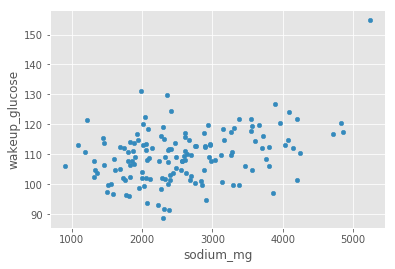

In [318]:
data.loc['132178'].plot.scatter(x='sodium_mg', y='wakeup_glucose')

In PNP3 patients probably avoided alcohol due to the diet. I should exclude this feature from the correlation analysis.

In [470]:
# spearmancorr = data.corr(method='spearman')
# spearmancorr

In [469]:
# sb.heatmap(pearsoncorr, 
#             xticklabels=pearsoncorr.columns,
#             yticklabels=pearsoncorr.columns,
#             cmap='RdBu_r',
#             annot=True,
#             linewidth=0.5)

In [362]:
# def calculate_pvalues(df):
#     df = df.dropna()._get_numeric_data()
#     dfcols = pd.DataFrame(columns=df.columns)
#     pvalues = dfcols.transpose().join(dfcols, how='outer')
#     for r in df.columns:
#         for c in df.columns:
#             pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
#     return pvalues

# calculate_pvalues(data.loc['111527']) 

In [365]:
data = data.drop(columns='alcohol_g')

In [374]:
data = round(data, 4)

In [396]:
data = data.fillna(0)

In [412]:
statistics_df = pd.DataFrame(means.stack(level=-1))

In [413]:
statistics_df['rho'] = 0
statistics_df['pvalue'] = 0
statistics_df = statistics_df.drop(columns=0)

In [415]:
statistics_df.head()

rho  pvalue
RegistrationCode                            
111527           wakeup_glucose    0       0
                 sodium_mg         0       0
                 sugarstotal_g     0       0
                 alcohol_g         0       0
                 totallipid_g      0       0

In [417]:
for rc in data.index.unique():
    for column in data.columns:
        spearman = spearmanr(data.loc[rc]['wakeup_glucose'], data.loc[rc][column])
        statistics_df.loc[(rc, column), 'rho'] = spearman[0]
        statistics_df.loc[(rc, column), 'pvalue'] = spearman[1]

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [454]:
pvalues = statistics_df['pvalue']

In [455]:
pvalues = pvalues.fillna(1)

In [458]:
# from statsmodels.stats.multitest import multipletests
# multipletests(pvalues, alpha=0.05, method='fdr_by', is_sorted=False, returnsorted=False)

(array([ True, False, False, ...,  True, False, False]),
 array([0.        , 1.        , 1.        , ..., 0.00164012, 0.87594188,
        1.        ]),
 1.9607336209315207e-05,
 1.9113149847094803e-05)

In [456]:
pvalues_corrected = pd.Series(fdrcorrection(pvalues[1])

In [462]:
pvalues_corrected.index = statistics_df.index

In [463]:
statistics_df['pvalues_corrected'] = pvalues_corrected
statistics_df.head()

rho    pvalue  pvalues_corrected
RegistrationCode                                                      
111527           wakeup_glucose  1.000000  0.000000           0.000000
                 sodium_mg       0.008531  0.922064           0.975776
                 sugarstotal_g   0.116687  0.179374           0.407329
                 alcohol_g       0.000000  0.000000           0.000000
                 totallipid_g   -0.190140  0.027770           0.105132

In [465]:
statistics_df[(statistics_df['rho'] > 0.3) & (statistics_df['pvalues_corrected'] < 0.05) & 
              (statistics_df.index.get_level_values(-1) != 'wakeup_glucose')]

rho        pvalue  pvalues_corrected
RegistrationCode                                                          
126092           weight          0.316931  1.906980e-04       1.065953e-03
12752            caffeine_mg     0.436133  7.342705e-05       4.203176e-04
136529           energy_kcal     0.372959  3.191714e-05       1.847240e-04
158748           carbohydrate_g  0.318045  8.427241e-04       4.508315e-03
                 caffeine_mg     0.325417  6.257751e-04       3.382288e-03
...                                   ...           ...                ...
933765           carbohydrate_g  0.435482  1.074835e-08       6.434253e-08
                 energy_kcal     0.368453  1.904740e-06       1.122252e-05
                 carbs/lipids    0.355952  4.433299e-06       2.600339e-05
997735           energy_kcal     0.316560  3.046739e-04       1.685046e-03
                 weight          0.360568  3.362357e-05       1.941706e-04

[62 rows x 3 columns]

In [472]:
statistics_df['significant'] = 0

In [476]:

statistics_df.loc[(statistics_df['pvalues_corrected'] < 0.05),'significant'] = 1

In [477]:
statistics_df.head()

rho  ...  significant
RegistrationCode                           ...             
111527           wakeup_glucose  1.000000  ...            1
                 sodium_mg       0.008531  ...            0
                 sugarstotal_g   0.116687  ...            0
                 alcohol_g       0.000000  ...            1
                 totallipid_g   -0.190140  ...            0

[5 rows x 4 columns]

In [468]:
# for rc in data.index.unique():
#     for column in data.columns:
#         pearson = pearsonr(data.loc[rc]['wakeup_glucose'], data.loc[rc][column])
#         if abs(pearson[0]) > 0.3 and pearson[1] < 0.05 and column != 'wakeup_glucose':
#             print(rc, column, pearson)

In [494]:
statistics_df = statistics_df.fillna(0)

In [498]:
statistics_df.dtypes

RegistrationCode      object
level_1               object
rho                  float64
pvalue               float64
pvalues_corrected    float64
significant            int64
dtype: object

In [503]:
statistics_df = statistics_df.reset_index('RegistrationCode')

In [499]:
print(statistics_df['level_1'], statistics_df['rho'])

0            wakeup_glucose
1                 sodium_mg
2             sugarstotal_g
3                 alcohol_g
4              totallipid_g
               ...         
2611    totaldietaryfiber_g
2612            energy_kcal
2613                 weight
2614            caffeine_mg
2615           carbs/lipids
Name: level_1, Length: 2616, dtype: object 0       1.000000
1       0.008531
2       0.116687
3       0.000000
4      -0.190140
          ...   
2611    0.292845
2612    0.316560
2613    0.360568
2614    0.196802
2615    0.137503
Name: rho, Length: 2616, dtype: float64


In [506]:
sns.catplot(x='level_1', y='rho', data=statistics_df[(statistics_df['RegistrationCode'] =='158748') | (statistics_df['RegistrationCode'] =='111527')]);

In [510]:
statistics_df.loc[(statistics_df['significant'] == 0), 'rho'] = None

In [515]:
statistics_df = statistics_df[(statistics_df['level_1'] != 'wakeup_glucose') & (statistics_df['level_1'] != 'alcohol_g')]

In [512]:
statistics_df.head()

RegistrationCode        level_1  ...  pvalues_corrected  significant
1           111527      sodium_mg  ...           0.975776            0
2           111527  sugarstotal_g  ...           0.407329            0
3           111527      alcohol_g  ...           0.000000            1
4           111527   totallipid_g  ...           0.105132            0
5           111527      protein_g  ...           0.983639            0

[5 rows x 6 columns]

In [517]:
signif_corr = statistics_df.set_index(['RegistrationCode', 'level_1']).unstack(level=-1)['rho']

In [518]:
signif_corr.columns.name = None

In [521]:
signif_corr.columns

Index(['caffeine_mg', 'carbohydrate_g', 'carbs/lipids', 'energy_kcal',
       'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g',
       'totallipid_g', 'weight'],
      dtype='object')

In [522]:
rc_list = signif_corr.index
rc_list = ['rc' + item for item in rc_list]
diet_feat_list = signif_corr.columns

In [523]:
sign_corr_list = signif_corr.values.tolist()

In [526]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=sign_corr_list,
                   x=diet_feat_list,
                   y=rc_list,
                   hoverongaps = False))
fig.update_layout(
    title={
        'text': "Personalized correlations between the wakeup glucose and dietary features from the day before",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Dietary features",
    yaxis_title="RegistrationCode"
    )
#fig.write_html("/home/elming/Cache/plotly_figures/personalized_corr_pnp3.html")
fig.show()